# 18/08/2022

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

from utils.data_processing import get_dates_str, download_and_prepare_data, load_spread_btc_eth
from utils.kernels import Kernel
from utils.estimation import estimate_parameters_tvAR_p, forecast_future_values_tvAR_p 
from utils.interpolation import interpolate_and_extrapolate, plot_interpolation, extrapolate_parameters
from utils.trading import get_actions_and_forecasts, launch_trading_simulation1, launch_trading_simulation2, launch_trading_simulation3

sns.set_style("whitegrid")

In [12]:
def make_general_plots(time_series, p=1, k=3):
    # MODELLING
    u_list = np.linspace(0, 1, 100, endpoint=False)
    T = time_series.shape[0]
    b_T = 0.1 * T ** (-1/5)
    print(f"{T=}")
    print(f"{b_T=}")

    theta_hat = estimate_parameters_tvAR_p(time_series=time_series, p=p, u_list=u_list, kernel=Kernel("epanechnikov"), bandwidth=b_T)
    alpha_hat = theta_hat[:, :-1, :].squeeze(axis=2)
    sigma_hat = theta_hat[:, -1, :].squeeze()

    # PLOT DATA TIME SERIES + COEFFICIENTS TIME SERIES
    fig = plt.figure(constrained_layout=True)
    subfigs = fig.subfigures(3, 1)
    # spread time series
    ax = subfigs[0].subplots(1, 1)
    ax.plot(time_series)
    ax.set_title("Spread")
    # alpha
    axs = subfigs[1].subplots(1, p) if p > 1 else [subfigs[1].subplots(1, p)]
    for i in range(p):
        axs[i].plot(u_list, alpha_hat[:, i])
        axs[i].set_title(f"alpha_{i+1}")
    # sigma
    ax = subfigs[2].subplots(1, 1)
    ax.plot(u_list, sigma_hat)
    ax.set_title("sigma")

    # PLOT ACF / PACF
    fig2, axs2 = plt.subplots(1, 2)
    pacf_, conf_int = pacf(time_series, nlags=10, alpha=0.05)
    plot_pacf(time_series, method='ywm', ax=axs2[0], lags=np.arange(10), alpha=0.05, markersize=3)
    plot_acf(time_series, ax=axs2[1], lags=np.arange(10), alpha=0.05, markersize=3)

    # PLOT Interpolation for one coefficient
    fig, ax = plt.subplots()
    alpha_interpolation = interpolate_and_extrapolate(alpha_hat[:, 0], k=k)
    plot_interpolation(alpha_hat[:, 0], alpha_interpolation, ax)
    
    # PLOT forecast of the time series
    fig, ax = plt.subplots()
    alpha_extrapolated, sigma_extrapolated = extrapolate_parameters(alpha_hat, sigma_hat, num_points=10, interpol_step=1, n_forecasts=1, k=3) # shape (n_forecasts, alpha_hat.shape[1])
    preds = forecast_future_values_tvAR_p(alpha_extrapolated, time_series)
    ax.plot(np.arange(19, 20+len(preds)), np.concatenate([[time_series[-1]], preds]), color='red', label='prediction')
    ax.plot(np.arange(20), time_series[-20:], label='time series')
    ax.set_title("last 20 points of the time series + forecast")
    ax.legend()

def plot_rolling_entries(time_series, spread_time_series, n_forecasts=50, n_last_points=80, p=1, k=3):
    (actions, forecasts, z_list) = get_actions_and_forecasts(time_series=time_series, n_forecasts=n_forecasts, p=p, k=k)
    print(scipy.stats.spearmanr(time_series[-n_forecasts:], forecasts))
    
    # Plot figure
    ## time series and forecasts
    fig, ax = plt.subplots()
    x = np.arange(n_last_points)
    ax.plot(x, time_series[-n_last_points:])
    ax.plot(x[-n_forecasts:], forecasts, color='red', label='forecasts')
    ax.vlines(x[-n_forecasts], time_series[-n_last_points:].min(),
              time_series[-n_last_points:].max(), color='red', linestyle='--', label='forecasts begin here')
    ax.scatter(x[-n_forecasts + np.argwhere(actions == 'LONG')] - 1,
               time_series[-n_forecasts + np.argwhere(actions == 'LONG') - 1], marker='^', color='green', label='Open LONG')
    ax.scatter(x[-n_forecasts + np.argwhere(actions == 'SHORT') - 1],
               time_series[-n_forecasts + np.argwhere(actions == 'SHORT') - 1], marker='v', color='black', label='Open SHORT')
    ax.set_title(f"Trade Signals ({k=}, {p=})")
    ax.legend()
    ## spread time series
    fig, ax = plt.subplots()
    ax.plot(x, spread_time_series[-n_last_points:])
    ax.scatter(x[-n_forecasts + np.argwhere(actions == 'LONG')] - 1,
               spread_time_series[-n_forecasts + np.argwhere(actions == 'LONG') - 1], marker='^', color='green', label='Open LONG')
    ax.scatter(x[-n_forecasts + np.argwhere(actions == 'SHORT') - 1],
               spread_time_series[-n_forecasts + np.argwhere(actions == 'SHORT') - 1], marker='v', color='black', label='Open SHORT')
    ## z
    fig, ax = plt.subplots()
    ax.plot(x[-n_forecasts:], z_list, color='green', label='z')

## Trading strategies

### Parameters

In [2]:
p = 1       # order of the tvAR(p)
k = 3       # order of the spline interpolation
T = 10_000  # length of each time series
n_simulations = 2000 # number of hours for the trading simulation

### Data

In [ ]:
end_date = '2021-12-31' # '2022-08-14' max
start, end = get_dates_str(n_simulations + T - 1, end_date)
data_df = load_spread_btc_eth(start, end)

time_series = data_df['spread_log_returns'].to_numpy()
spread_time_series = data_df['spread'].to_numpy()

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
sns.lineplot(data=data_df, x=data_df.index, y="spread_log_returns", ax=axs[0]);
sns.lineplot(data=data_df, x=data_df.index, y="spread", ax=axs[1]);

### Strategy 1

- Open position at time $t$ if $|z| > 1$
- Close position at time $t+1$

In [ ]:
portfolio_1, actions_1, forecasts_1 = launch_trading_simulation1(data_df, T, p, k, )


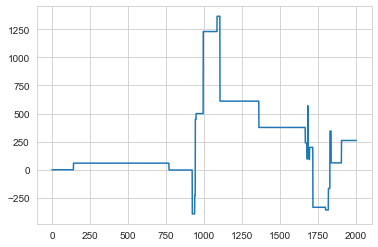

In [37]:
pnl_series_1 = pd.read_csv('data/pnl_simulations/pnl_series_strat1-end2021.csv', index_col='datetime')

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(pnl_series_1.to_numpy());

In [33]:
pnl_series_1

,0
datetime,
2021-10-08 16:00:00,0.00
2020-08-18 00:00:00,0.00
2020-08-18 01:00:00,0.00
2020-08-18 02:00:00,0.00
2020-08-18 03:00:00,0.00
...,...
2020-11-09 04:00:00,260.26
2020-11-09 05:00:00,260.26
2020-11-09 06:00:00,260.26
